In [166]:
import numpy as np
import matplotlib.pyplot as plt
from gauss_sadel import Gauss_Sadel

In [167]:
Ly        = 1 # Length of the plate
Lx        = 1

num_nodes_x = 5
num_nodes_y = 5

del_x     = round(Lx / num_nodes_x, 2)
del_y     = round(Ly / num_nodes_y, 2)

k         = 1000

# T South : Temperature | 15
# T East  : Flux        | 5000
# T North : Temperature | 10
# T West  : Insulated   | 

q_E       = 0  # uniform heat generation

T_N       = 100 # North Side
T_S       = 100

In [168]:
nodes = []
n = 1
for i in range(num_nodes_x):
    l = []
    for j in range(num_nodes_y):
        l.append(n)
        n+=1
    nodes.append(l)

# nodes = nodes[::-1]
nodes = np.fliplr(np.array(nodes)).transpose()
nodes = np.array(nodes)

for i in nodes:
    print(i)

[ 5 10 15 20 25]
[ 4  9 14 19 24]
[ 3  8 13 18 23]
[ 2  7 12 17 22]
[ 1  6 11 16 21]


In [169]:
def linear_to_flipped_coords(index, num_rows):
    col = index // num_rows
    row_from_bottom = index % num_rows
    row = num_rows - 1 - row_from_bottom
    return (row, col)

def find_neighbors(row, col):
    """!!!!!!!!!!!! Remeber that it returns node number not index !!!!!!!!!!!!"""
    north = nodes[row-1][col] if row > 0 else None
    south = nodes[row+1][col] if row < num_nodes_y - 1 else None
    west = nodes[row][col-1] if col > 0 else None
    east = nodes[row][col+1] if col < num_nodes_x - 1 else None
    return {'north': north, 'east': east, 'south': south, 'west': west}

find_neighbors(1,1)

{'north': 10, 'east': 14, 'south': 8, 'west': 4}

In [170]:
coef_matrix = np.zeros((num_nodes_y*num_nodes_x, num_nodes_y*num_nodes_x))
Su_vector = np.zeros_like(coef_matrix[:,0])
coef_matrix.shape

(25, 25)

In [171]:
for node_idx in range(num_nodes_x * num_nodes_y): #num_nodes_x * num_nodes_y)
    print(f"Processing node {node_idx}")
    cell_x, cell_y = linear_to_flipped_coords(node_idx, num_nodes_x)
    print(f"Coordinates: ({cell_x}, {cell_y})")
    nei_dict = find_neighbors(cell_x, cell_y)
    print(f"Neighbors: {nei_dict}")


    a_N = a_S = a_E = a_W = 0
    Su = 0
    nei_dict = find_neighbors(cell_x, cell_y)

    # Bottom edge: Dirichlet T=15 (excluding corners)
    if nei_dict['south'] is None and nei_dict['east'] is not None and nei_dict['west'] is not None:
        a_E = k / del_x
        a_N = k / del_y  
        a_W = k / del_x
        a_S = k / (del_y / 2)  # Half-cell for Dirichlet
        
        a_P = a_E + a_N + a_S + a_W
        Su = a_S * T_S
        
        coef_matrix[node_idx, node_idx] = a_P
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    # Top edge: Dirichlet T=10 (excluding corners)  
    elif nei_dict['north'] is None and nei_dict['east'] is not None and nei_dict['west'] is not None:
        a_E = k / del_x
        a_S = k / del_y
        a_W = k / del_x
        a_N = k / (del_y / 2)  # Half-cell for Dirichlet
        
        a_P = a_E + a_N + a_S + a_W
        Su = a_N * T_N
        
        coef_matrix[node_idx, node_idx] = a_P
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    # Right edge: Neumann q = 5000
    elif nei_dict['east'] is None:
        # Handling corner combinations
        a_N = k / (del_y / 2) if nei_dict['north'] is None else k / del_y
        a_S = k / (del_y / 2) if nei_dict['south'] is None else k / del_y
        a_W = k / del_x if nei_dict['west'] is not None else 0
        
        # Add Dirichlet contributions for corners
        if nei_dict['north'] is None:
            Su += a_N * T_N  # Top-right corner
        if nei_dict['south'] is None:
            Su += a_S * T_S  # Bottom-right corner
            
        a_P = a_E + a_N + a_S + a_W
        Su += q_E * del_y  # Heat flux
        
        coef_matrix[node_idx, node_idx] = a_P
        if nei_dict['north'] is not None:
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        if nei_dict['south'] is not None:
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        if nei_dict['west'] is not None:
            coef_matrix[node_idx, nei_dict['west'] - 1] = a_W

    elif nei_dict['west'] is None:
        # Determine coefficients based on corner status
        if nei_dict['north'] is None and nei_dict['south'] is not None:
            # Top-left corner
            a_N = k / (del_y / 2)  # Dirichlet north
            a_S = k / del_y        # Interior south
            a_E = k / del_x        # Interior east
            Su = a_N * T_N          # North temperature
            
        elif nei_dict['south'] is None and nei_dict['north'] is not None:
            # Bottom-left corner  
            a_N = k / del_y        # Interior north
            a_S = k / (del_y / 2)  # Dirichlet south
            a_E = k / del_x        # Interior east
            Su = a_S * T_S          # South temperature
        else:
            # Regular west edge (interior north and south)
            a_N = k / del_y
            a_S = k / del_y
            a_E = k / del_x
            Su = 0  
        
        a_W = 0  # Always zero for west boundary
        a_P = a_E + a_N + a_S + a_W
        
        coef_matrix[node_idx, node_idx] = a_P
        if nei_dict['north'] is not None:
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        if nei_dict['south'] is not None:
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        
    else:  # Interior or other edges not handled above
        # Assign available neighbor coefficients safely
        if nei_dict['north'] is not None:
            a_N = (k) / del_y
            coef_matrix[node_idx, nei_dict['north'] - 1] = a_N
        else:
            a_N = 0

        if nei_dict['south'] is not None:
            a_S = k / del_y
            coef_matrix[node_idx, nei_dict['south'] - 1] = a_S
        else:
            a_S = 0

        if nei_dict['east'] is not None:
            a_E = k / del_x
            coef_matrix[node_idx, nei_dict['east'] - 1] = a_E
        else:
            a_E = 0

        if nei_dict['west'] is not None:
            a_W = k / del_x
            coef_matrix[node_idx, nei_dict['west'] - 1] = a_W
        else:
            a_W = 0
        
        a_P = a_E + a_N + a_S + a_W
        coef_matrix[node_idx, node_idx] = a_P
        
    
    Su_vector[node_idx] = Su
    print(a_P, end="\n\n")


Processing node 0
Coordinates: (4, 0)
Neighbors: {'north': 2, 'east': 6, 'south': None, 'west': None}
20000.0

Processing node 1
Coordinates: (3, 0)
Neighbors: {'north': 3, 'east': 7, 'south': 1, 'west': None}
15000.0

Processing node 2
Coordinates: (2, 0)
Neighbors: {'north': 4, 'east': 8, 'south': 2, 'west': None}
15000.0

Processing node 3
Coordinates: (1, 0)
Neighbors: {'north': 5, 'east': 9, 'south': 3, 'west': None}
15000.0

Processing node 4
Coordinates: (0, 0)
Neighbors: {'north': None, 'east': 10, 'south': 4, 'west': None}
20000.0

Processing node 5
Coordinates: (4, 1)
Neighbors: {'north': 7, 'east': 11, 'south': None, 'west': 1}
25000.0

Processing node 6
Coordinates: (3, 1)
Neighbors: {'north': 8, 'east': 12, 'south': 6, 'west': 2}
20000.0

Processing node 7
Coordinates: (2, 1)
Neighbors: {'north': 9, 'east': 13, 'south': 7, 'west': 3}
20000.0

Processing node 8
Coordinates: (1, 1)
Neighbors: {'north': 10, 'east': 14, 'south': 8, 'west': 4}
20000.0

Processing node 9
Coordin

In [172]:
# Making non diagnol element negetive
mask = ~np.eye(coef_matrix.shape[0], dtype=bool)
coef_matrix[mask] = -coef_matrix[mask]


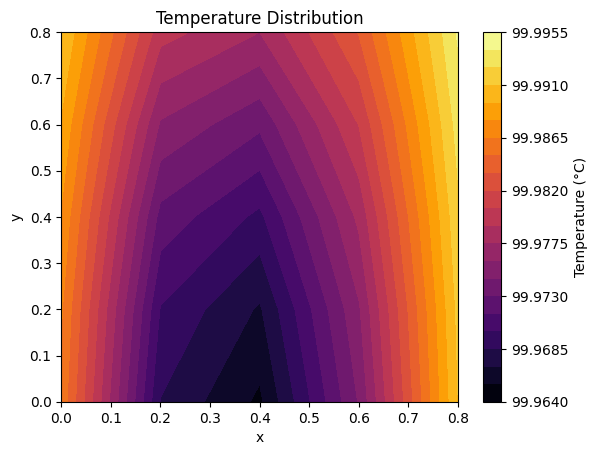

In [173]:
X, loops_taken = Gauss_Sadel(coef_matrix, Su_vector, np.zeros_like(Su_vector),
                             tolerance=1e-4, max_loops=200)

# Reshape for 5×5 grid
X_grid = X.reshape(5, 5)

# Create coordinates  
x = np.linspace(0, 4*del_x, 5)
y = np.linspace(0, 4*del_y, 5)
X_coords, Y_coords = np.meshgrid(x, y)

# Plot
plt.contourf(X_coords, Y_coords, X_grid, levels=20, cmap='inferno')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution')
plt.show()

In [174]:
X

array([99.98604657, 99.9684359 , 99.96519331, 99.97462354, 99.99098104,
       99.98669176, 99.9698954 , 99.96680276, 99.97579695, 99.99139808,
       99.98782585, 99.97246085, 99.96963176, 99.97785949, 99.99213112,
       99.98930058, 99.97579685, 99.97331047, 99.98054153, 99.99308434,
       99.99098098, 99.97959809, 99.97750222, 99.98359759, 99.99417048])